# Introduction

In this notebook, we perform **GI tract semantic image segmentation** using TransU-Net. 

**Libraries**

In [2]:
# Core
import pandas as pd
import numpy as np
import os
import cv2
import gc
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from glob import glob
import warnings
warnings.filterwarnings("ignore")
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold
import random

# Keras
from tensorflow import keras
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.models import load_model, save_model

In [32]:
import tensorflow.keras as tfk

import math
import scipy

**Reproducibility**

In [3]:
# Set random seeds
def set_seed(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
set_seed()

**Config**

In [38]:
BATCH_SIZE = 4
EPOCHS = 10
n_splits = 5
fold_selected = 2   # 1,...,5
im_width = 320
im_height = 320

# Data

**Train set**

In [5]:
# Train set
train_df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/train.csv')
print(train_df.shape)
train_df.head()

(115488, 3)


,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


**Test set**

*Note:* This is a code competition, which means the 'real' test set will be populated at inference time.

In [6]:
# Test set
test_df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/sample_submission.csv')

if len(test_df)==0:
    DEBUG=True
    test_df = train_df.iloc[:10*16*3,:]
    test_df["segmentation"]=''
    test_df=test_df.rename(columns={"segmentation":"predicted"})
else:
    DEBUG=False

submission=test_df.copy()
test_df.head()

,id,class,predicted
0,case123_day20_slice_0001,large_bowel,
1,case123_day20_slice_0001,small_bowel,
2,case123_day20_slice_0001,stomach,
3,case123_day20_slice_0002,large_bowel,
4,case123_day20_slice_0002,small_bowel,


# Preprocessing

**Metadata**

In [7]:
# Metadata
def preprocessing(df, subset="train"):
    #--------------------------------------------------------------------------
    df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
    df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
    df["slice"] = df["id"].apply(lambda x: x.split("_")[3])
    #--------------------------------------------------------------------------
    if (subset=="train") or (DEBUG):
        DIR="../input/uw-madison-gi-tract-image-segmentation/train"
    else:
        DIR="../input/uw-madison-gi-tract-image-segmentation/test"
    
    all_images = glob(os.path.join(DIR, "**", "*.png"), recursive=True)
    x = all_images[0].rsplit("/", 4)[0] ## ../input/uw-madison-gi-tract-image-segmentation/train

    path_partial_list = []
    for i in range(0, df.shape[0]):
        path_partial_list.append(os.path.join(x,
                              "case"+str(df["case"].values[i]),
                              "case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),
                              "scans",
                              "slice_"+str(df["slice"].values[i])))
    df["path_partial"] = path_partial_list
    #--------------------------------------------------------------------------
    path_partial_list = []
    for i in range(0, len(all_images)):
        path_partial_list.append(str(all_images[i].rsplit("_",4)[0]))

    tmp_df = pd.DataFrame()
    tmp_df['path_partial'] = path_partial_list
    tmp_df['path'] = all_images

    #--------------------------------------------------------------------------
    df = df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])
    #--------------------------------------------------------------------------
    df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
    df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
    #--------------------------------------------------------------------------
    del x, path_partial_list, tmp_df
    #--------------------------------------------------------------------------
    
    return df

In [8]:
train_df = preprocessing(train_df, subset="train")
train_df.head()

,id,class,segmentation,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
1,case123_day20_slice_0001,small_bowel,,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
2,case123_day20_slice_0001,stomach,,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
3,case123_day20_slice_0002,large_bowel,,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266
4,case123_day20_slice_0002,small_bowel,,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266


In [9]:
test_df=preprocessing(test_df, subset="test")
test_df.head()

,id,class,predicted,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
1,case123_day20_slice_0001,small_bowel,,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
2,case123_day20_slice_0001,stomach,,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
3,case123_day20_slice_0002,large_bowel,,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266
4,case123_day20_slice_0002,small_bowel,,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266


**Restructure df**

In [10]:
# Restructure
def restructure(df, subset="train"):
    # RESTRUCTURE  DATAFRAME
    df_out = pd.DataFrame({'id': df['id'][::3]})

    if subset=="train":
        df_out['large_bowel'] = df['segmentation'][::3].values
        df_out['small_bowel'] = df['segmentation'][1::3].values
        df_out['stomach'] = df['segmentation'][2::3].values

    df_out['path'] = df['path'][::3].values
    df_out['case'] = df['case'][::3].values
    df_out['day'] = df['day'][::3].values
    df_out['slice'] = df['slice'][::3].values
    df_out['width'] = df['width'][::3].values
    df_out['height'] = df['height'][::3].values

    df_out=df_out.reset_index(drop=True)
    df_out=df_out.fillna('')
    if subset=="train":
        df_out['count'] = np.sum(df_out.iloc[:,1:4]!='',axis=1).values
    
    return df_out

In [11]:
train_df=restructure(train_df, subset="train")
train_df.head()

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
0,case123_day20_slice_0001,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0001,266,266,0
1,case123_day20_slice_0002,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0002,266,266,0
2,case123_day20_slice_0003,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0003,266,266,0
3,case123_day20_slice_0004,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0004,266,266,0
4,case123_day20_slice_0005,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0005,266,266,0


In [12]:
test_df=restructure(test_df, subset="test")
test_df.head()

,id,path,case,day,slice,width,height
0,case123_day20_slice_0001,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0001,266,266
1,case123_day20_slice_0002,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0002,266,266
2,case123_day20_slice_0003,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0003,266,266
3,case123_day20_slice_0004,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0004,266,266
4,case123_day20_slice_0005,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0005,266,266


**Remove mislabelled data**

In [13]:
# Remove mislabeled training data
train_df = train_df[(train_df['case']!=7)|(train_df['day']!=0)].reset_index(drop=True)
train_df = train_df[(train_df['case']!=81)|(train_df['day']!=30)].reset_index(drop=True)

In [14]:
# Garbage collection
gc.collect()

137

# Helper functions

**RLE encoding**

In [15]:
# Run-length encoding
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1D
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

**Metrics**

In [16]:
# Metrics
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + dice_loss(tf.cast(y_true, tf.float32), y_pred)

**Data generator**

In [17]:
# Images reshaped to (im_height,im_width)
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size = BATCH_SIZE, subset="train", shuffle=False):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.indexes = np.arange(len(df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        X = np.empty((self.batch_size,im_height,im_width,3))
        y = np.empty((self.batch_size,im_height,im_width,3))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i, img_path in enumerate(self.df['path'].iloc[indexes]):
            w=self.df['width'].iloc[indexes[i]]
            h=self.df['height'].iloc[indexes[i]]
            img = self.__load_grayscale(img_path)  # shape: (im_height,im_width,1)
            X[i,] = img   # broadcast to shape: (im_height,im_width,3)
            if self.subset == 'train':
                for k,j in enumerate(["large_bowel","small_bowel","stomach"]):
                    rles = self.df[j].iloc[indexes[i]]
                    mask = rle_decode(rles, shape=(h, w, 1))
                    mask = cv2.resize(mask, (im_height,im_width))
                    y[i,:,:,k] = mask
        if self.subset == 'train':
            return X, y
        else: 
            return X
        
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        dsize = (im_height,im_width)
        img = cv2.resize(img, dsize)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)
        return img

# EDA

**Target distribution**

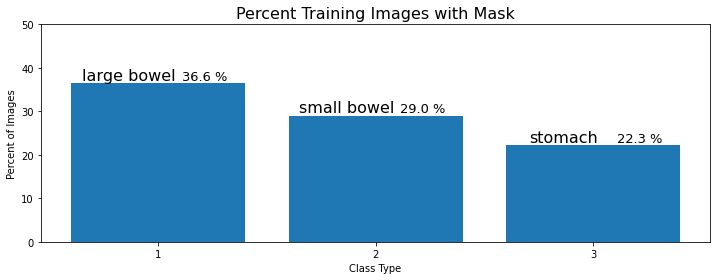

In [18]:
plt.figure(figsize=(12,4))
bar = plt.bar([1,2,3],100*np.mean(train_df.iloc[:,1:4]!='',axis=0))
plt.title('Percent Training Images with Mask', fontsize=16)
plt.ylabel('Percent of Images'); plt.xlabel('Class Type')
plt.xticks([1,2,3])
labels=["large bowel","small bowel","stomach"]
for rect, lbl in zip(bar, labels):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/3, height,  lbl,
             ha='center', va='bottom',fontsize=16)
    plt.text(rect.get_x() + rect.get_width()/1.3, height, '%.1f %%' % height,
             ha='center', va='bottom',fontsize=13)

plt.ylim((0,50))
plt.show()

**Preview some samples**

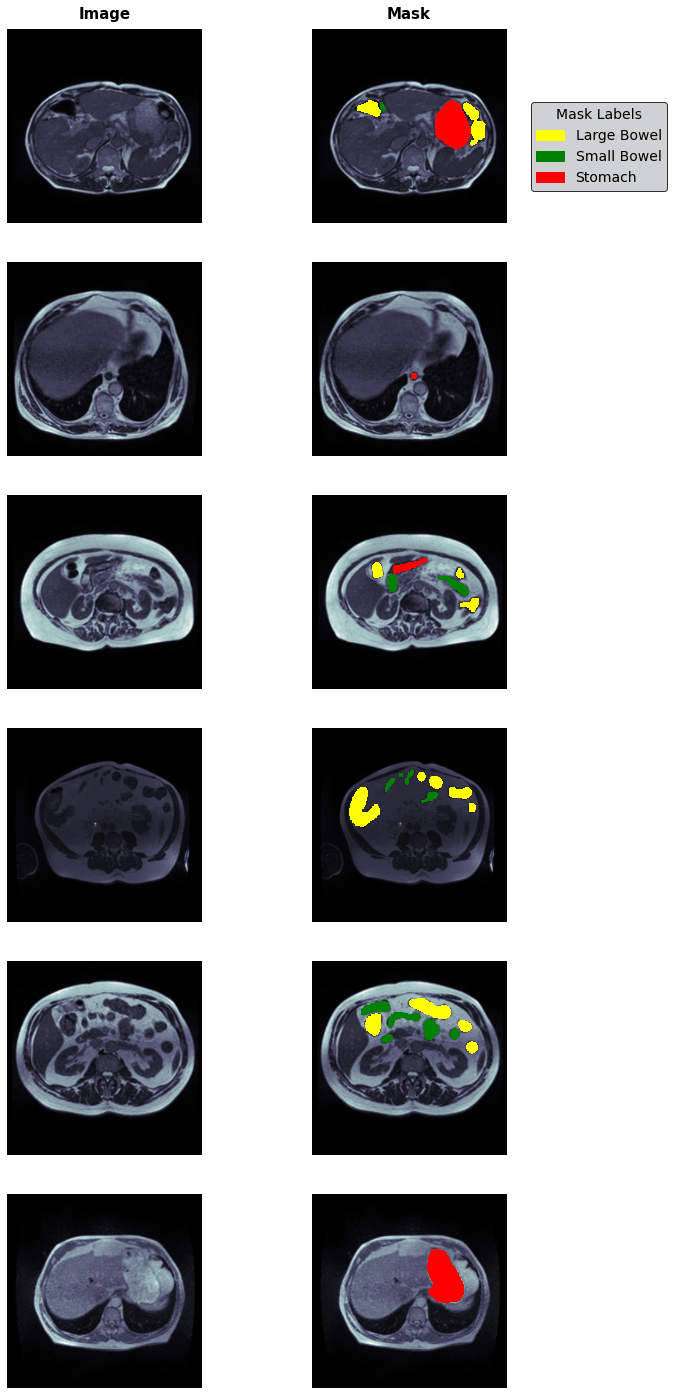

In [19]:
# SAMPLES
Masks = list(train_df[train_df['large_bowel']!=''].sample(BATCH_SIZE).index)
Masks += list(train_df[train_df['small_bowel']!=''].sample(BATCH_SIZE*2).index)
Masks += list(train_df[train_df['stomach']!=''].sample(BATCH_SIZE*3).index)

# DATA GENERATOR
View_batches = DataGenerator(train_df[train_df.index.isin(Masks)],shuffle=True)

# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=6, ncols=2)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

for i in range(6):
    images, mask = View_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')

    ax1 = fig.add_subplot(gs[i, 1])
    if i==0:
        ax0.set_title("Image", fontsize=15, weight='bold', y=1.02)
        ax1.set_title("Mask", fontsize=15, weight='bold', y=1.02)
        plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 14,title='Mask Labels', title_fontsize=14, edgecolor="black",  facecolor='#c5c6c7')

    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    _ = [ax.set_axis_off() for ax in [ax0,ax1]]

    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]

# Cross-validation

**Group k-fold**

In [20]:
# Group by case id
skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X=train_df, y=train_df['count'], groups=train_df['case']), 1):
    train_df.loc[val_idx, 'fold'] = fold

train_df['fold'] = train_df['fold'].astype(np.uint8)

train_ids = train_df[train_df["fold"]!=fold_selected].index
valid_ids = train_df[train_df["fold"]==fold_selected].index

X_train = train_df[train_df.index.isin(train_ids)]
X_valid = train_df[train_df.index.isin(valid_ids)]

train_df.groupby('fold').size()

fold
1    8160
2    6080
3    8192
4    9152
5    6624
dtype: int64

In [21]:
# Fold sizes
train_df.groupby(['fold','count'])['id'].count()

fold  count
1     0        4857
      1         475
      2        2155
      3         673
2     0        3412
      1         294
      2        1793
      3         581
3     0        4622
      1         537
      2        2278
      3         755
4     0        5160
      1         744
      2        2596
      3         652
5     0        3718
      1         396
      2        2012
      3         498
Name: id, dtype: int64

**Debugging**

In [22]:
# Check submission format works
experimental=False
if experimental:
    X_train=X_train[X_train.case.isin(X_train.case.unique()[:5])]       # take first few cases
    X_valid=X_valid[X_valid.case.isin(X_valid.case.unique()[:2])]       # take first few cases
    
print('X_train shape:', X_train.shape)
print('X_valid shape:', X_valid.shape)

X_train shape: (32128, 12)
X_valid shape: (6080, 12)


**Define generator**

In [23]:
train_generator = DataGenerator(X_train, shuffle=True)
val_generator = DataGenerator(X_valid)

# Trans U-Net model

### Utils

In [24]:
def apply_embedding_weights(target_layer, source_weights):
    """Apply embedding weights to a target layer.

    Args:
        target_layer: The target layer to which weights will
            be applied.
        source_weights: The source weights, which will be
            resized as necessary.
    """
    expected_shape = target_layer.weights[0].shape
    if expected_shape == source_weights.shape:
        grid = source_weights
    elif expected_shape[1] == source_weights.shape[1] - 1:
        grid = source_weights[:, 1:]
    else:
        _, grid = source_weights[0, :1], source_weights[0, 1:]
        sin = int(np.sqrt(grid.shape[0]))
        sout = int(np.sqrt(expected_shape[1]))
        warnings.warn(
            "Resizing position embeddings from " f"{sin} to {sout}",
            UserWarning,
        )
        zoom = (sout / sin, sout / sin, 1)
        grid = scipy.ndimage.zoom(grid.reshape(sin, sin, -1), zoom, order=1).reshape(
            1, sout * sout, -1
        )
    target_layer.set_weights([grid])


def load_weights_numpy(model, params_path):
    """Load weights saved using Flax as a numpy array.

    Args:
        model: A Keras model to load the weights into.
        params_path: Filepath to a numpy archive.
    """
    params_dict = np.load(
        params_path, allow_pickle=False
    )  # pylint: disable=unexpected-keyword-arg
    source_keys = list(params_dict.keys())

    source_keys_used = []
    n_transformers = len(
        set(
            "/".join(k.split("/")[:2])
            for k in source_keys
            if k.startswith("Transformer/encoderblock_")
        )
    )
    n_transformers_out = sum(
        l.name.startswith("Transformer/encoderblock_") for l in model.layers
    )
    assert n_transformers == n_transformers_out, (
        f"Wrong number of transformers ("
        f"{n_transformers_out} in model vs. {n_transformers} in weights)."
    )

    matches = []
    for tidx in range(n_transformers):
        encoder = model.get_layer(f"Transformer/encoderblock_{tidx}")
        source_prefix = f"Transformer/encoderblock_{tidx}"
        matches.extend(
            [
                {
                    "layer": layer,
                    "keys": [
                        f"{source_prefix}/{norm}/{name}" for name in ["scale", "bias"]
                    ],
                }
                for norm, layer in [
                    ("LayerNorm_0", encoder.layernorm1),
                    ("LayerNorm_2", encoder.layernorm2),
                ]
            ]
            + [
                {
                    "layer": encoder.mlpblock.get_layer(
                        f"{source_prefix}/Dense_{mlpdense}"
                    ),
                    "keys": [
                        f"{source_prefix}/MlpBlock_3/Dense_{mlpdense}/{name}"
                        for name in ["kernel", "bias"]
                    ],
                }
                for mlpdense in [0, 1]
            ]
            + [
                {
                    "layer": layer,
                    "keys": [
                        f"{source_prefix}/MultiHeadDotProductAttention_1/{attvar}/{name}"
                        for name in ["kernel", "bias"]
                    ],
                    "reshape": True,
                }
                for attvar, layer in [
                    ("query", encoder.att.query_dense),
                    ("key", encoder.att.key_dense),
                    ("value", encoder.att.value_dense),
                    ("out", encoder.att.combine_heads),
                ]
            ]
        )

    # Embedding kernel and bias
    matches.append(
        {
            "layer": model.get_layer("embedding"),
            "keys": [f"embedding/{name}" for name in ["kernel", "bias"]],
        }
    )

    matches.append(
        {
            "layer": model.get_layer("Transformer/encoder_norm"),
            "keys": [f"Transformer/encoder_norm/{name}" for name in ["scale", "bias"]],
        }
    )
    apply_embedding_weights(
        target_layer=model.get_layer("Transformer/posembed_input"),
        source_weights=params_dict["Transformer/posembed_input/pos_embedding"],
    )
    source_keys_used.append("Transformer/posembed_input/pos_embedding")
    for match in matches:
        source_keys_used.extend(match["keys"])
        source_weights = [params_dict[k] for k in match["keys"]]
        if match.get("reshape", False):
            source_weights = [
                source.reshape(expected.shape)
                for source, expected in zip(
                    source_weights, match["layer"].get_weights()
                )
            ]
        match["layer"].set_weights(source_weights)

In [25]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl
class AddPositionEmbs(tfkl.Layer):
    """Adds (optionally learned) positional embeddings to the inputs."""

    def __init__(self, trainable=True, **kwargs):
        super().__init__(trainable=trainable, **kwargs)
        self.trainable = trainable

    def build(self, input_shape):
        assert (
            len(input_shape) == 3
        ), f"Number of dimensions should be 3, got {len(input_shape)}"
        self.pe = tf.Variable(
            name="pos_embedding",
            initial_value=tf.random_normal_initializer(stddev=0.06)(
                shape=(1, input_shape[1], input_shape[2])
            ),
            dtype="float32",
            trainable=self.trainable,
        )

    def call(self, inputs):
        return inputs + tf.cast(self.pe, dtype=inputs.dtype)


class MultiHeadSelfAttention(tfkl.Layer):
    def __init__(self, *args, trainable=True, n_heads, **kwargs):
        super().__init__(trainable=trainable, *args, **kwargs)
        self.n_heads = n_heads

    def build(self, input_shape):
        hidden_size = input_shape[-1]
        n_heads = self.n_heads
        if hidden_size % n_heads != 0:
            raise ValueError(
                f"embedding dimension = {hidden_size} should be divisible by number of heads = {n_heads}"
            )
        self.hidden_size = hidden_size
        self.projection_dim = hidden_size // n_heads
        self.query_dense = tfkl.Dense(hidden_size, name="query")
        self.key_dense = tfkl.Dense(hidden_size, name="key")
        self.value_dense = tfkl.Dense(hidden_size, name="value")
        self.combine_heads = tfkl.Dense(hidden_size, name="out")

    # pylint: disable=no-self-use
    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], score.dtype)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.n_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.hidden_size))
        output = self.combine_heads(concat_attention)
        return output, weights


class TransformerBlock(tfkl.Layer):
    """Implements a Transformer block."""

    def __init__(self, *args, n_heads, mlp_dim, dropout, trainable=True, **kwargs):
        super().__init__(*args, trainable=trainable, **kwargs)
        self.n_heads = n_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout

    def build(self, input_shape):
        self.att = MultiHeadSelfAttention(
            n_heads=self.n_heads,
            name="MultiHeadDotProductAttention_1",
        )
        self.mlpblock = tfk.Sequential(
            [
                tfkl.Dense(
                    self.mlp_dim, activation="linear", name=f"{self.name}/Dense_0"
                ),
                tfkl.Lambda(lambda x: tfk.activations.gelu(x, approximate=False))
                if hasattr(tfk.activations, "gelu")
                else tfkl.Lambda(lambda x: tfa.activations.gelu(x, approximate=False)),
                tfkl.Dropout(self.dropout),
                tfkl.Dense(input_shape[-1], name=f"{self.name}/Dense_1"),
                tfkl.Dropout(self.dropout),
            ],
            name="MlpBlock_3",
        )
        self.layernorm1 = tfkl.LayerNormalization(epsilon=1e-6, name="LayerNorm_0")
        self.layernorm2 = tfkl.LayerNormalization(epsilon=1e-6, name="LayerNorm_2")
        self.dropout = tfkl.Dropout(self.dropout)

    def call(self, inputs, training):
        x = self.layernorm1(inputs)
        x, weights = self.att(x)
        x = self.dropout(x, training=training)
        x = x + inputs
        y = self.layernorm2(x)
        y = self.mlpblock(y)
        return x + y, weights


def resnet_embeddings(x, image_size=224, n_skip=3):
    """Get resnet embeddings for Decoder"""
    resnet50v2 = tfk.applications.ResNet50V2(
        weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3)
    )
    _ = resnet50v2(x)
    layers = ["conv3_block4_preact_relu", "conv2_block3_preact_relu", "conv1_conv"]
    features = []
    if n_skip > 0:
        for l in layers:
            features.append(resnet50v2.get_layer(l).output)
    return resnet50v2, features

In [26]:
L2_WEIGHT_DECAY = 1e-4


class SegmentationHead(tfkl.Layer):
    def __init__(
        self,
        name="seg_head",
        num_classes=9,
        kernel_size=1,
        final_act="sigmoid",
        **kwargs
    ):
        super(SegmentationHead, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.kernel_size = kernel_size
        self.final_act = final_act

    def build(self, input_shape):
        self.conv = tfkl.Conv2D(
            filters=self.num_classes,
            kernel_size=self.kernel_size,
            padding="same",
            kernel_regularizer=tfk.regularizers.L2(L2_WEIGHT_DECAY),
            kernel_initializer=tfk.initializers.LecunNormal(),
        )
        self.act = tfkl.Activation(self.final_act)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.act(x)
        return x


class Conv2DReLu(tfkl.Layer):
    def __init__(self, filters, kernel_size, padding="same", strides=1, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.strides = strides

    def build(self, input_shape):
        self.conv = tfkl.Conv2D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding=self.padding,
            use_bias=False,
            kernel_regularizer=tfk.regularizers.L2(L2_WEIGHT_DECAY),
            kernel_initializer="lecun_normal",
        )

        self.bn = tfkl.BatchNormalization(momentum=0.9, epsilon=1e-5)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = tf.nn.relu(x)
        return x


class DecoderBlock(tfkl.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        self.conv1 = Conv2DReLu(filters=self.filters, kernel_size=3)
        self.conv2 = Conv2DReLu(filters=self.filters, kernel_size=3)
        self.upsampling = tfkl.UpSampling2D(size=2, interpolation="bilinear")

    def call(self, inputs, skip=None):
        x = self.upsampling(inputs)
        if skip is not None:
            x = tf.concat([x, skip], axis=-1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class DecoderCup(tfkl.Layer):
    def __init__(self, decoder_channels, n_skip=3, **kwargs):
        super().__init__(**kwargs)
        self.decoder_channels = decoder_channels
        self.n_skip = n_skip

    def build(self, input_shape):
        self.conv_more = Conv2DReLu(filters=512, kernel_size=3)
        self.blocks = [DecoderBlock(filters=out_ch) for out_ch in self.decoder_channels]

    def call(self, hidden_states, features):
        x = self.conv_more(hidden_states)
        for i, decoder_block in enumerate(self.blocks):
            if features is not None:
                skip = features[i] if (i < self.n_skip) else None
            else:
                skip = None
            x = decoder_block(x, skip=skip)
        return x


In [27]:
MODELS_URL = "https://storage.googleapis.com/vit_models/imagenet21k/"


def load_pretrained(model, fname="R50+ViT-B_16.npz"):
    """Load model weights for a known configuration."""
    origin = MODELS_URL + fname
    local_filepath = tf.keras.utils.get_file(fname, origin, cache_subdir="weights")
    load_weights_numpy(model, local_filepath)


def TransUNet(
    image_size=224,
    patch_size=16,
    hybrid=True,
    grid=(14, 14),
    resnet_n_layers=(3, 4, 9),
    hidden_size=768,
    n_layers=12,
    n_heads=12,
    mlp_dim=3072,
    dropout=0.1,
    decoder_channels=[256, 128, 64, 16],
    n_skip=3,
    num_classes=3,
    final_act="sigmoid",
    pretrain=True,
    freeze_enc_cnn=True,
    name="TransUNet",
):
    # Tranformer Encoder
    assert image_size % patch_size == 0, "image_size must be a multiple of patch_size"
    x = tf.keras.layers.Input(shape=(image_size, image_size, 3))

    #  CNN + Transformer
    if hybrid:
        grid_size = grid
        patch_size = image_size // 16 // grid_size[0]
        if patch_size == 0:
            patch_size = 1
        resnet50v2, features = resnet_embeddings(
            x, image_size=image_size, n_skip=n_skip
        )
        if freeze_enc_cnn:
            resnet50v2.trainable = False
        y = resnet50v2.get_layer("conv4_block6_preact_relu").output
        x = resnet50v2.input
    else:
        y = x
        features = None

    y = tfkl.Conv2D(
        filters=hidden_size,
        kernel_size=patch_size,
        strides=patch_size,
        padding="valid",
        name="embedding",
        trainable=not freeze_enc_cnn,
    )(y)
    y = tfkl.Reshape((y.shape[1] * y.shape[2], hidden_size))(y)
    y = AddPositionEmbs(name="Transformer/posembed_input", trainable=True)(y)

    y = tfkl.Dropout(0.1)(y)

    # Transformer/Encoder
    for n in range(n_layers):
        y, _ = TransformerBlock(
            n_heads=n_heads,
            mlp_dim=mlp_dim,
            dropout=dropout,
            name=f"Transformer/encoderblock_{n}",
            trainable=True,
        )(y)
    y = tfkl.LayerNormalization(epsilon=1e-6, name="Transformer/encoder_norm")(y)

    n_patch_sqrt = int(math.sqrt(y.shape[1]))

    y = tfkl.Reshape(target_shape=[n_patch_sqrt, n_patch_sqrt, hidden_size])(y)

    # Decoder
    if len(decoder_channels):
        y = DecoderCup(decoder_channels=decoder_channels, n_skip=n_skip)(y, features)

    # Segmentation Head
    y = SegmentationHead(num_classes=num_classes, final_act=final_act)(y)

    # Build Model
    model = tfk.models.Model(inputs=x, outputs=y, name=name)

    # Load Pretrain Weights
    if pretrain:
        load_pretrained(model)

    return model

In [40]:
def get_model(name="TransUNet", backbone="ResNet50V2"):
    model = TransUNet(image_size=im_width, freeze_enc_cnn=False, pretrain=True)


    model.compile(
        optimizer='adam',
        loss=bce_dice_loss,
        metrics=[
            dice_coef,
            iou_coef,
        ],
    )
    return model

**Define model**

In [42]:
model = get_model()
model.summary()

Model: "TransUNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 326, 326, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 160, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 162, 162, 64) 0           conv1_conv[0][0]                 
__________________________________________________________________________________________

# Training model

**Callbacks**

In [43]:
# Save best model at every epoch
checkpoint = ModelCheckpoint(
    'UNET_model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
)

# Stop early if no improvement seen
early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.0001,
    restore_best_weights=True,
)

# Cosine decay
'''
lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=2e-3,
    decay_steps=EPOCHS + 2, 
    alpha=0,
)
lr_schedule = keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
'''

# Reduce learning rate on plateau
lr_plateau = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=0,
    min_delta=0.0001,
)

**Train model**

In [44]:
# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, 
               #early_stopping, 
               lr_plateau],
    use_multiprocessing=False,
    workers=4,
    epochs=EPOCHS
)

Epoch 1/10
4016/4016 [==============================] - 2593s 641ms/step - loss: 0.8555 - dice_coef: 0.2232 - iou_coef: 0.0550 - val_loss: 0.9598 - val_dice_coef: 0.0994 - val_iou_coef: 0.0705

Epoch 00001: val_loss improved from inf to 0.95979, saving model to UNET_model
Epoch 2/10
4016/4016 [==============================] - 2576s 641ms/step - loss: 0.7883 - dice_coef: 0.2763 - iou_coef: 0.0758 - val_loss: 1.0126 - val_dice_coef: 0.0739 - val_iou_coef: 0.0974

Epoch 00002: val_loss did not improve from 0.95979
Epoch 3/10
4016/4016 [==============================] - 2576s 641ms/step - loss: 0.6777 - dice_coef: 0.3853 - iou_coef: 0.1398 - val_loss: 0.9247 - val_dice_coef: 0.1500 - val_iou_coef: 0.2416

Epoch 00003: val_loss improved from 0.95979 to 0.92474, saving model to UNET_model
Epoch 4/10
4016/4016 [==============================] - 2574s 641ms/step - loss: 0.6006 - dice_coef: 0.4532 - iou_coef: 0.1888 - val_loss: 0.9693 - val_dice_coef: 0.1062 - val_iou_coef: 0.1381

Epoch 00004

**Learning curves**

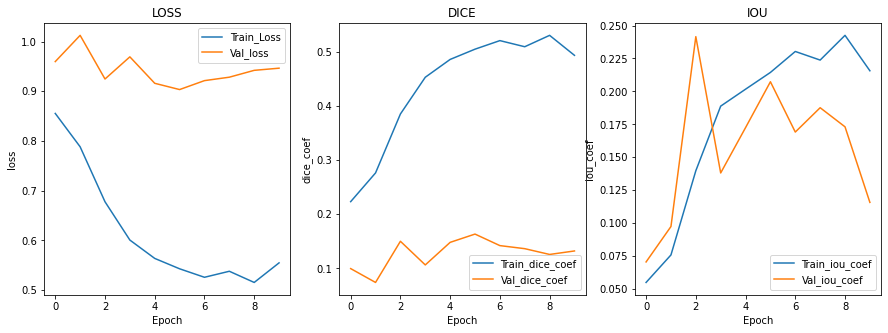

In [45]:
# History
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history.csv')

# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(history.epoch[-1]+1),history.history['loss'],label='Train_Loss')
plt.plot(range(history.epoch[-1]+1),history.history['val_loss'],label='Val_loss')
plt.title('LOSS'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend();

plt.subplot(1,3,2)
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='Train_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='Val_dice_coef')
plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('dice_coef');plt.legend(); 

plt.subplot(1,3,3)
plt.plot(range(history.epoch[-1]+1),history.history['iou_coef'],label='Train_iou_coef')
plt.plot(range(history.epoch[-1]+1),history.history['val_iou_coef'],label='Val_iou_coef')
plt.title('IOU'); plt.xlabel('Epoch'); plt.ylabel('iou_coef');plt.legend();
plt.show()

# Evaluation

**Save model (if checkpoint not used)**

In [ ]:
#save_model(model,'UNET_model')

'''
custom_objects = custom_objects={
    'dice_coef': dice_coef,
    'iou_coef': iou_coef,
    'bce_dice_loss': bce_dice_loss
}
model = load_model('./UNET_model', custom_objects=custom_objects)
'''

**Preview predictions**

In [ ]:
pred_batches = DataGenerator(X_valid.iloc[200:208,:], batch_size = 1, subset="train", shuffle=False)
preds = model.predict_generator(pred_batches,verbose=1)

Threshold = 0.5
# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=8, ncols=3)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

for i in range(8):
    images, mask = pred_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    pre=preds[i]
    predict1=pre[:,:,0]
    predict2=pre[:,:,1]
    predict3=pre[:,:,2]
    
    predict1= (predict1 > Threshold).astype(np.float32)
    predict2= (predict2 > Threshold).astype(np.float32)
    predict3= (predict3 > Threshold).astype(np.float32)
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')
    ax0.set_title("Image", fontsize=12, y=1.01)
    #--------------------------
    ax1 = fig.add_subplot(gs[i, 1])
    ax1.set_title("Mask", fontsize=12,  y=1.01)
    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    #--------------------------
    ax2 = fig.add_subplot(gs[i, 2])
    ax2.set_title("Predict", fontsize=12, y=1.01)
    l0 = ax2.imshow(sample_img, cmap='bone')
    l1 = ax2.imshow(np.ma.masked_where(predict1== False,  predict1),cmap=cmap1, alpha=1)
    l2 = ax2.imshow(np.ma.masked_where(predict2== False,  predict2),cmap=cmap2, alpha=1)
    l3 = ax2.imshow(np.ma.masked_where(predict3== False,  predict3),cmap=cmap3, alpha=1)
   

    _ = [ax.set_axis_off() for ax in [ax0,ax1,ax2]]
    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
    plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 12,title='Mask Labels', title_fontsize=12, edgecolor="black",  facecolor='#c5c6c7')


# Test set predictions

**Make predictions on test set**

In [ ]:
#gcd(80,144)=16=BATCH_SIZE
pred_batches = DataGenerator(test_df, batch_size = BATCH_SIZE, subset="test", shuffle=False)
num_batches = int(len(test_df)/BATCH_SIZE)

for i in range(num_batches):
    # Predict
    preds = model.predict(pred_batches[i],verbose=0)     # shape: (16,im_height,im_width,3)
    
    # Rle encode
    for j in range(BATCH_SIZE):
        for k in range(3):
            pred_img = cv2.resize(preds[j,:,:,k], (test_df.loc[i*BATCH_SIZE+j,"width"], test_df.loc[i*BATCH_SIZE+j,"height"]), interpolation=cv2.INTER_NEAREST) # resize probabilities to original shape
            pred_img = (pred_img>0.5).astype(dtype='uint8')    # classify
            submission.loc[3*(i*BATCH_SIZE+j)+k,'predicted'] = rle_encode(pred_img)

**Save predictions**

In [ ]:
submission.to_csv('submission.csv',index=False)
submission.sample(20)

**Acknowledgements:**
* [UWM - GI Tract Image Segmentation - EDA](https://www.kaggle.com/code/dschettler8845/uwm-gi-tract-image-segmentation-eda) by [Darien Schettler](https://www.kaggle.com/dschettler8845).
* [UWMGI: UNet Keras [Train] with EDA](https://www.kaggle.com/code/ammarnassanalhajali/uwmgi-unet-keras-train-with-eda) by [Ammar Alhaj Ali
](https://www.kaggle.com/ammarnassanalhajali).